In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import tqdm
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
precision = torch.float32
torch.set_default_dtype(precision)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(f'Device: {device}')

Device: cuda


In [5]:
class TimesSet(Dataset):
    def __init__(self, times):
        self.times = times

    def __len__(self):
        return len(self.times)

    def __getitem__(self, idx):
        time = self.times[idx]
        return time

In [6]:
class TrainableSin(nn.Module):
    def __init__(self):
        super(TrainableSin, self).__init__()
        self.beta = nn.Parameter(torch.as_tensor(1.0))

    def forward(self, x):
        x = x.sin() * self.beta
        return x

class TrainableSwish(nn.Module):
    def __init__(self):
        super(TrainableSwish, self).__init__()
        self.beta = nn.Parameter(torch.as_tensor(1.0))

    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)

class SinBlock(nn.Module):
    def __init__(self, hidden_size, depth):
        super(SinBlock, self).__init__()
        self.layers = nn.Sequential(*
            [nn.Linear(1, hidden_size), TrainableSin(), nn.Tanh()] + 
            [nn.Linear(hidden_size, hidden_size), TrainableSin(), nn.Tanh()] * depth
        )

    def forward(self, x):
        x = self.layers(x)
        return x

class PINN(nn.Module):
    def __init__(self, hidden_size, depth, sin_hidden_size, sin_depth):
        super(PINN, self).__init__()
        self.periodic = SinBlock(sin_hidden_size, sin_depth)
        self.layers = nn.Sequential(*
            [nn.Linear(1 + sin_hidden_size, hidden_size), TrainableSwish()] + 
            [nn.Linear(hidden_size, hidden_size), TrainableSwish()] * depth + 
            [nn.Linear(hidden_size, 1)]
        )

    def forward(self, t):
        global t_scaling, x_scaling
        t = t / t_scaling
        p = self.periodic(t)
        x = self.layers(torch.cat((t, p), dim=-1))
        return x / x_scaling

In [7]:
def loss_pde(model, t_pde, eps, g, gam, loss_func):
    x_pred = model(t_pde)
    vx_pred = autograd.grad(x_pred, t_pde, torch.ones_like(x_pred), retain_graph=True, create_graph=True)[0]
    ax_pred = autograd.grad(vx_pred, t_pde, torch.ones_like(vx_pred), retain_graph=True, create_graph=True)[0]
    f = ax_pred + eps * (x_pred ** 2 - 1) * vx_pred + x_pred - g * torch.cos(gam * t_pde)
    return loss_func(f, torch.zeros_like(f))

def loss_ic(model, t_ic, x_ic, vx_ic, loss_func):
    global t_scaling, x_scaling
    x_pred = model(t_ic)
    vx_pred = autograd.grad(x_pred, t_ic, torch.ones_like(x_pred), retain_graph=True, create_graph=True)[0]
    loss_ic_x = loss_func(x_pred, x_ic)
    loss_ic_vx = loss_func(vx_pred, vx_ic)
    return loss_ic_x + loss_ic_vx

def l2_regularization(model, lambda_l2):
    l2_loss = 0
    for param in model.parameters():
        l2_loss += lambda_l2 * torch.sum(param ** 2)
    return l2_loss

def total_loss(model, t_pde, t_ic, x_ic, vx_ic, eps, g, gam, loss_func, l2_reg):
    return loss_pde(model, t_pde, eps, g, gam, loss_func) * 1 + \
           loss_ic(model, t_ic, x_ic, vx_ic, loss_func) * 0.1 + \
           l2_regularization(model, l2_reg)

In [8]:
# Parameters
eps = torch.tensor(1.0, dtype=precision)
g = torch.tensor(0.0, dtype=precision)
gam = torch.tensor(torch.pi * 2, dtype=precision)

t_end = 6

t_scaling = torch.tensor(1 / t_end, dtype=precision)
x_scaling = torch.tensor(1 / 10, dtype=precision)

In [9]:
# Generate collocation points
t_pde = torch.arange(0, t_end + 5e-2, 5e-2, dtype=precision).view(-1, 1).to(device)

# Initial conditions
t_ic = torch.tensor([0.0], dtype=precision).view(-1, 1).to(device)
x_ic = torch.tensor([1.0], dtype=precision).view(-1, 1).to(device)
vx_ic = torch.tensor([0.0], dtype=precision).view(-1, 1).to(device)

In [10]:
t_pde.requires_grad = True
t_ic.requires_grad = True

In [11]:
dataset = TimesSet(t_pde)
loader = DataLoader(dataset, batch_size=32768, shuffle=True)
len(loader)

1

In [12]:
# Initialize the model, loss function, optimizer and hyperparameters
model = PINN(hidden_size=2048, depth=3, sin_hidden_size=64, sin_depth=0).to(device)
loss_func = nn.MSELoss().to(device)

pre_training_optimizer = optim.Adam(model.parameters(), lr=1e-4)
pre_training_scheduler = optim.lr_scheduler.ReduceLROnPlateau(pre_training_optimizer, factor=0.95, patience=10, threshold=4e-2)
#pre_training_optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.5)
pre_training_epochs = 512

fine_tuning_optimizer = optim.LBFGS(model.parameters(), lr=2.5e-1, history_size=50, line_search_fn="strong_wolfe")
fine_tuning_epochs = 512

print(model, sum([p.numel() for p in model.parameters()]))

PINN(
  (periodic): SinBlock(
    (layers): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): TrainableSin()
      (2): Tanh()
    )
  )
  (layers): Sequential(
    (0): Linear(in_features=65, out_features=2048, bias=True)
    (1): TrainableSwish()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): TrainableSwish()
    (4): Linear(in_features=2048, out_features=2048, bias=True)
    (5): TrainableSwish()
    (6): Linear(in_features=2048, out_features=2048, bias=True)
    (7): TrainableSwish()
    (8): Linear(in_features=2048, out_features=1, bias=True)
  )
) 4333700


In [13]:
writer = SummaryWriter("logs/")
writer.add_graph(model, torch.tensor([0, 1], dtype=precision).view(-1, 1).to(device))
writer.close()

In [14]:
# Pre-training loop
pbar = tqdm.tqdm(range(pre_training_epochs))
pre_training_loss_hist = {'epoch': [], 'loss': [], 'lr': []}
for i in pbar:
    losses = []
    for ts in loader:
        pre_training_optimizer.zero_grad()
        loss = total_loss(model, ts, t_ic, x_ic, vx_ic, eps, g, gam, loss_func, l2_reg=1e-6)
        loss.backward()
        pre_training_optimizer.step()
        losses.append(loss.item())
    current_loss = np.mean(losses)
    pre_training_scheduler.step(current_loss)
    pbar.set_description(f'Pre-training loss: {"{:.6f}".format(current_loss)}')
    pre_training_loss_hist['epoch'].append(i + 1)
    pre_training_loss_hist['loss'].append(current_loss)
    pre_training_loss_hist['lr'].append(pre_training_scheduler.get_last_lr())

Pre-training loss: 0.076434: 100%|██████████| 512/512 [00:21<00:00, 23.88it/s]


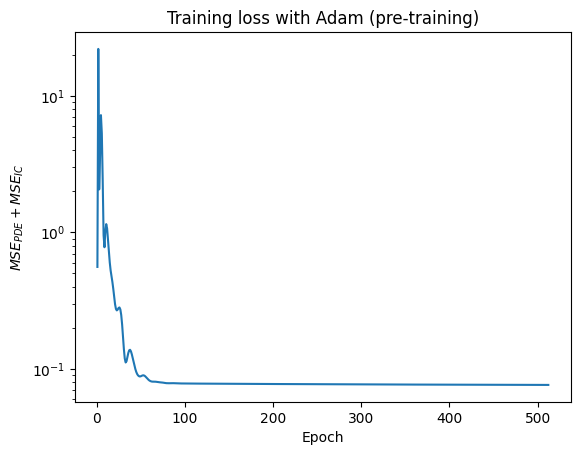

In [15]:
plt.title('Training loss with Adam (pre-training)')
plt.plot(pre_training_loss_hist['epoch'], pre_training_loss_hist['loss'])
plt.xlabel('Epoch')
plt.ylabel(r'$MSE_{PDE} + MSE_{IC}$')
plt.yscale('log')

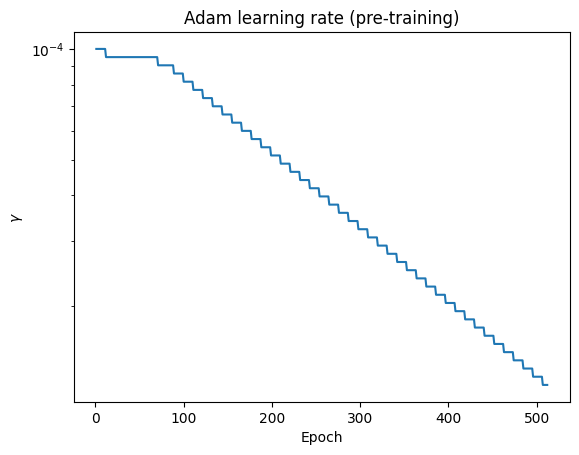

In [16]:
plt.title('Adam learning rate (pre-training)')
plt.plot(pre_training_loss_hist['epoch'], pre_training_loss_hist['lr'])
plt.xlabel('Epoch')
plt.ylabel(r'$\gamma$')
plt.yscale('log')

In [17]:
# Fine-tuning loop
pbar = tqdm.tqdm(range(fine_tuning_epochs))
fine_tuning_loss_hist = {'epoch': [], 'loss': []}

def closure():
    global current_loss, ts
    fine_tuning_optimizer.zero_grad()
    loss = total_loss(model, ts, t_ic, x_ic, vx_ic, eps, g, gam, loss_func, l2_reg=0)
    loss.backward()
    current_loss = loss.item()
    return loss

for i in pbar:
    current_loss = None
    losses = []
    for ts in loader:
        fine_tuning_optimizer.step(closure)
        losses.append(current_loss)
    current_loss = np.mean(losses)
    pbar.set_description(f'Fine-tuning loss: {"{:.6f}".format(current_loss)}')
    fine_tuning_loss_hist['epoch'].append(pre_training_loss_hist['epoch'][-1] + i + 1)
    fine_tuning_loss_hist['loss'].append(current_loss)

Fine-tuning loss: 0.000001: 100%|██████████| 512/512 [01:34<00:00,  5.40it/s]


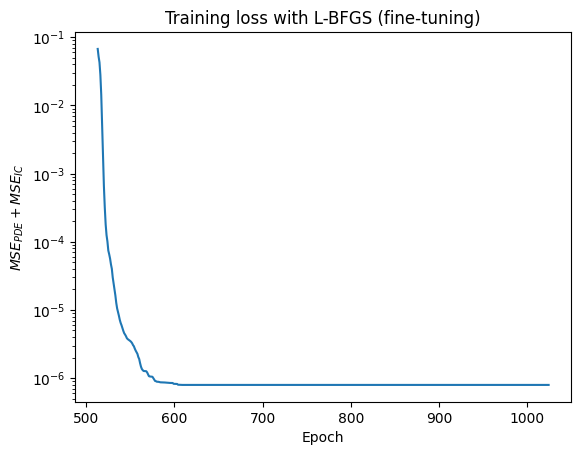

In [18]:
plt.title('Training loss with L-BFGS (fine-tuning)')
plt.plot(fine_tuning_loss_hist['epoch'], fine_tuning_loss_hist['loss'])
plt.xlabel('Epoch')
plt.ylabel(r'$MSE_{PDE} + MSE_{IC}$')
plt.yscale('log')

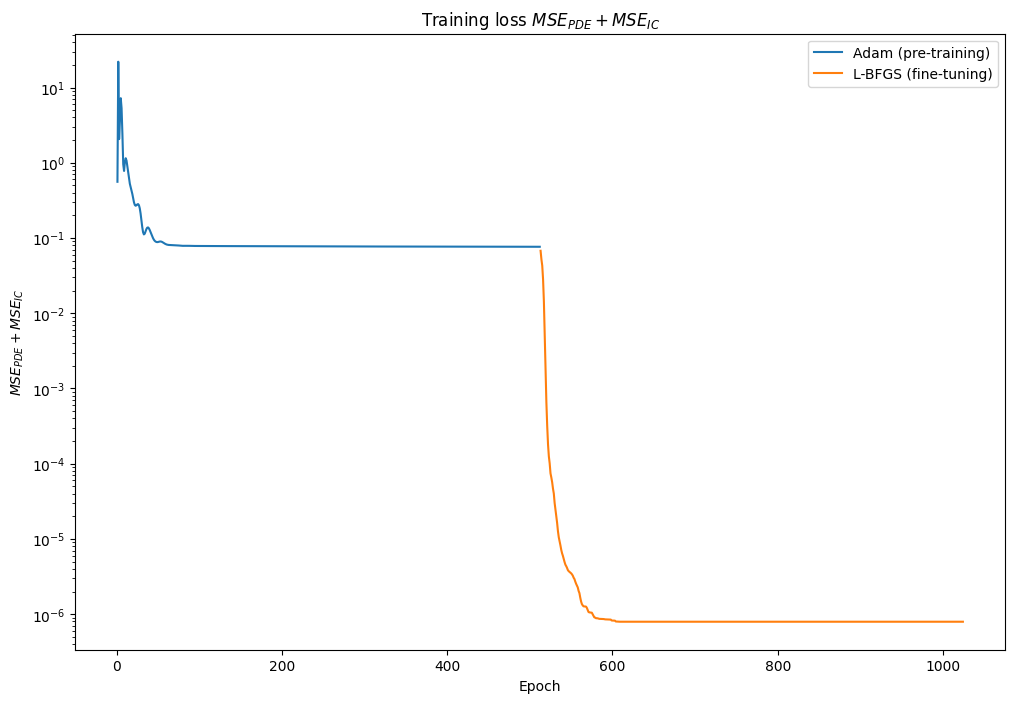

In [19]:
plt.figure(figsize=(12, 8))
plt.title(r'Training loss $MSE_{PDE} + MSE_{IC}$')
plt.plot(pre_training_loss_hist['epoch'], pre_training_loss_hist['loss'], label='Adam (pre-training)')
plt.plot(fine_tuning_loss_hist['epoch'], fine_tuning_loss_hist['loss'], label='L-BFGS (fine-tuning)')
plt.xlabel('Epoch')
plt.ylabel(r'$MSE_{PDE} + MSE_{IC}$')
plt.yscale('log')
plt.legend()

In [20]:
def solve_Euler_Cauchy(x0, vx0, t, dt, eps, g, gam):
    x = [x0]
    vx = [vx0]
    t_ = [0]
    for t_now in tqdm.tqdm(np.arange(dt, t + dt, dt)):
        vx.append(vx[-1] + (-eps * ((x[-1] ** 2) - 1) * vx[-1] - x[-1] + g * np.cos(gam * t_now)) * dt)
        x.append(x[-1] + (vx[-2] + vx[-1]) / 2 * dt)
        t_.append(t_now)
    return t_, x, vx

t_ec, x_ec, vx_ec = solve_Euler_Cauchy(x_ic.item(), vx_ic.item(), t_end, 1e-3, eps.item(), g.item(), gam.item())

100%|██████████| 6000/6000 [00:00<00:00, 849221.30it/s]


In [21]:
t_test = torch.tensor(t_ec, dtype=precision).view(-1, 1).to(device)
t_test.requires_grad = True

model.eval()
x_pred = model(t_test)
vx_pred = autograd.grad(x_pred, t_test, torch.ones_like(x_pred), retain_graph=True, create_graph=True)[0]
ax_pred = autograd.grad(vx_pred, t_test, torch.ones_like(vx_pred), retain_graph=True, create_graph=True)[0]

In [22]:
t_test = t_test.to('cpu').detach().numpy().reshape(-1)
x_pred = x_pred.to('cpu').detach().numpy().reshape(-1)
vx_pred = vx_pred.to('cpu').detach().numpy().reshape(-1)

t_ec = np.array(t_ec).reshape(-1)
x_ec = np.array(x_ec).reshape(-1)
vx_ec = np.array(vx_ec).reshape(-1)

In [23]:
l2_x = ((x_pred - x_ec) ** 2) ** 0.5
l2_vx = ((vx_pred - vx_ec) ** 2) ** 0.5
l2_x_vx = ((x_pred - x_ec) ** 2 + (vx_pred - vx_ec) ** 2) ** 0.5

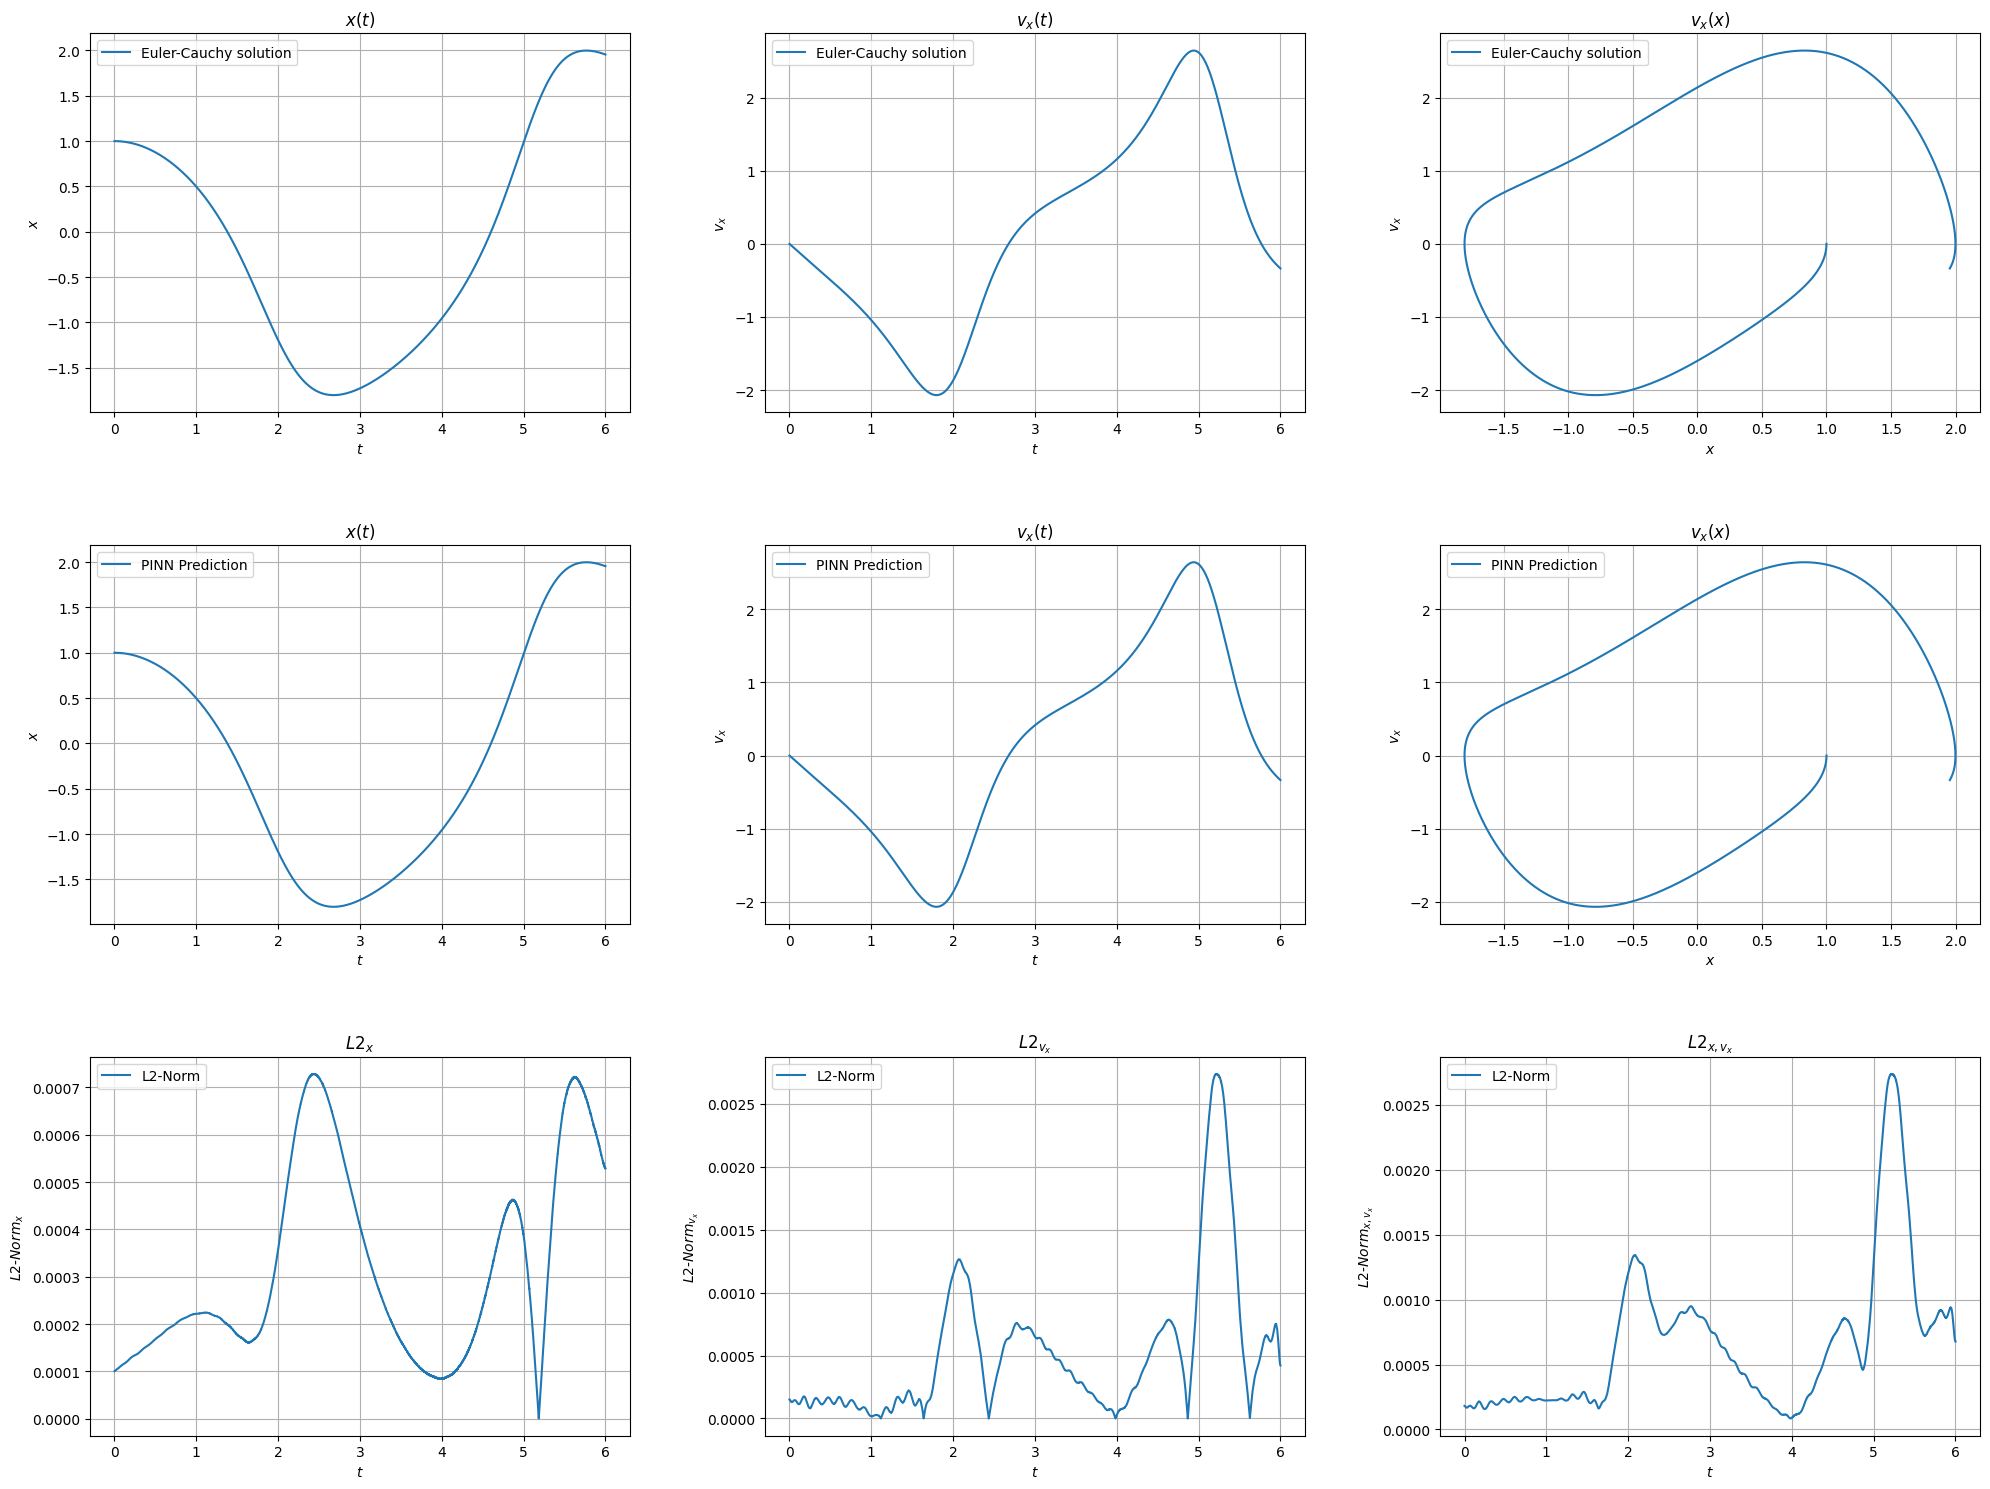

In [24]:
fig, axs = plt.subplots(3, 3, figsize=(20, 15), dpi=100)

axs[0, 0].set_title(r'$x(t)$')
axs[0, 0].plot(t_ec, x_ec, label='Euler-Cauchy solution')
axs[0, 0].set_xlabel(r'$t$')
axs[0, 0].set_ylabel(r'$x$')
axs[0, 0].legend()
axs[0, 0].grid()

axs[0, 1].set_title(r'$v_x(t)$')
axs[0, 1].plot(t_ec, vx_ec, label='Euler-Cauchy solution')
axs[0, 1].set_xlabel(r'$t$')
axs[0, 1].set_ylabel(r'$v_x$')
axs[0, 1].legend()
axs[0, 1].grid()

axs[0, 2].set_title(r'$v_x(x)$')
axs[0, 2].plot(x_ec, vx_ec, label='Euler-Cauchy solution')
axs[0, 2].set_xlabel(r'$x$')
axs[0, 2].set_ylabel(r'$v_x$')
axs[0, 2].legend()
axs[0, 2].grid()

axs[1, 0].set_title(r'$x(t)$')
axs[1, 0].plot(t_test, x_pred, label='PINN Prediction')
axs[1, 0].set_xlabel(r'$t$')
axs[1, 0].set_ylabel(r'$x$')
axs[1, 0].legend()
axs[1, 0].grid()

axs[1, 1].set_title(r'$v_x(t)$')
axs[1, 1].plot(t_test, vx_pred, label='PINN Prediction')
axs[1, 1].set_xlabel(r'$t$')
axs[1, 1].set_ylabel(r'$v_x$')
axs[1, 1].legend()
axs[1, 1].grid()

axs[1, 2].set_title(r'$v_x(x)$')
axs[1, 2].plot(x_pred, vx_pred, label='PINN Prediction')
axs[1, 2].set_xlabel(r'$x$')
axs[1, 2].set_ylabel(r'$v_x$')
axs[1, 2].legend()
axs[1, 2].grid()

axs[2, 0].set_title(r'$L2_{x}$')
axs[2, 0].plot(t_test, l2_x, label='L2-Norm')
axs[2, 0].set_xlabel(r'$t$')
axs[2, 0].set_ylabel(r'$L2$-$Norm_{x}$')
axs[2, 0].legend()
axs[2, 0].grid()

axs[2, 1].set_title(r'$L2_{v_x}$')
axs[2, 1].plot(t_test, l2_vx, label='L2-Norm')
axs[2, 1].set_xlabel(r'$t$')
axs[2, 1].set_ylabel(r'$L2$-$Norm_{v_x}$')
axs[2, 1].legend()
axs[2, 1].grid()

axs[2, 2].set_title(r'$L2_{x, v_x}$')
axs[2, 2].plot(t_ec, l2_x_vx, label='L2-Norm')
axs[2, 2].set_xlabel(r'$t$')
axs[2, 2].set_ylabel(r'$L2$-$Norm_{x, v_x}$')
axs[2, 2].legend()
axs[2, 2].grid()

fig.tight_layout()
fig.subplots_adjust(wspace=0.25, hspace=0.35)

plt.show()